### **Section 01 Project**

**다음 분기에 어떤 게임을 설계해야 할까**

라는 고민을 해결하기 위해, 기존의 데이터에 기반하여 인사이트를 얻고, 의사결정을 하고자 하는 것이 여러분의 목표입니다.

아래의 링크를 통해 파일을 다운로드 받으세요.

https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv

🕹️ Data Description


*   Name : 게임의 이름입니다.
*   Platform : 게임이 지원되는 플랫폼의 이름입니다.
*   Platform : 게임이 지원되는 플랫폼의 이름입니다.
*   Year : 게임이 출시된 연도입니다.
*   Genre : 게임의 장르입니다.
*   Publisher : 게임을 제작한 회사입니다.
*   NA_Sales : 북미지역에서의 출고량입니다.
*   EU_Sales : 유럽지역에서의 출고량입니다.
*   JP_Sales : 일본지역에서의 출고량입니다.
*   Other_Sales : 기타지역에서의 출고량입니다.



In [51]:
#from google.colab import drive
#drive.mount('/content/drive')

## **데이터 전처리 하기**



*   데이터 불러오기
*   결측치를 확인하고 처리하기
*   'Year' column의 단위 처리하기( M(1,000,000) 단위로 통일한다. 이때에 M단위 통일하지만 약자로 M을 사용한다는 가정하에 단위를 통일한다.  )
*   기본적인 데이터 프레임 만들기
*   앞으로 사용할 데이터는 1993 ~ 2021로 기준을 정한다.   




In [52]:
import pandas as pd
import numpy as np

df_m = pd.read_csv('/content/drive/MyDrive/vgames2.csv')
df = df_m.copy()

#df.isna().sum()

#df[df['NA_Sales'].str.contains('M')]

df = df.drop(df.columns[0], axis=1)
df.Year.fillna(1111, inplace=True)

for i ,row in df.iterrows():
  if df.at[i,'Year'] < 20:
        df.at[i,'Year'] += 2000
  elif df.at[i,'Year'] > 85 and df.at[i,'Year'] < 99:
        df.at[i,'Year'] += 1900 
  elif df.at[i,'Year'] == 1111:
        df.at[i,'Year'] = 0

df = df.sort_values(by='Year' ,ascending=False)
df.reset_index(drop=True,inplace=True)
df.Year = df.Year.astype(int)


#df.loc[df['Genre'].isna()]

df.fillna('Unknown', inplace=True)

def tounit(n):
    if 'M' in n:
      n = n[:-1]
    elif 'K' in n:
      n = float(n[:-1])/1000
    else:
      float(n)
    return n

df['NA_Sales'] = df['NA_Sales'].apply(tounit).astype(float)
df['EU_Sales'] = df['EU_Sales'].apply(tounit).astype(float)
df['JP_Sales'] = df['JP_Sales'].apply(tounit).astype(float)
df['Other_Sales'] = df['Other_Sales'].apply(tounit).astype(float)

df['Total_Sales'] = df[df.columns[5:]].sum(axis=1)
df

#df1 = df[df.Genre == 'Platform']
#df1

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Imagine: Makeup Artist,DS,2020,Simulation,Ubisoft,0.27,0.00,0.00,0.02,0.29
1,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017,Role-Playing,Sega,0.00,0.00,0.03,0.00,0.03
2,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017,Role-Playing,Sega,0.00,0.00,0.01,0.00,0.01
3,Brothers Conflict: Precious Baby,PSV,2017,Action,Idea Factory,0.00,0.00,0.01,0.00,0.01
4,Diabolik Lovers: Lunatic Parade,PSV,2016,Adventure,Idea Factory,0.00,0.00,0.03,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...
16593,PDC World Championship Darts 2008,DS,0,Sports,Unknown,0.01,0.00,0.00,0.00,0.01
16594,Dinotopia: The Sunstone Odyssey,GC,0,Action,Unknown,0.01,0.00,0.00,0.00,0.01
16595,LEGO Harry Potter: Years 5-7,3DS,0,Action,Warner Bros. Interactive Entertainment,0.18,0.19,0.00,0.04,0.41
16596,Def Jam: Fight for NY,XB,0,Fighting,Electronic Arts,0.43,0.10,0.00,0.02,0.55


## 1. **장르와 지역은 연관 되어있나**
(카이제곱검정)

 귀무가설 : 장르와 지역은 서로 독립니다.

*   p-value의 값이 (1.1498914890498152e-89)로 0.05보다 작기에 귀무가설을 기각한다.
*   결과 : 장르와 지역은 서로 연관성이 있다.


 




In [53]:
from scipy.stats import chi2_contingency


df_g = df[(df.Year>1993) & (df.Year<2021)] # 기준을 많은 플렛폼의 보급을 기준으로 했다

df_g = df_g.groupby('Genre').sum().iloc[:-1,1:-1]
df_g
chi, pvalue, _, _ = chi2_contingency(observed = df_g, correction=False )
chi, pvalue

(631.7518867784866, 7.344081144278235e-112)



*   시각화를 위해 tidy 데이터 프레임을 만들어준다.




In [54]:
df_g['Total_Sales'] = df_g.apply(lambda row: sum([row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]), axis=1)
df_g = df_g.sort_values(by='Total_Sales' ,ascending=False)

df_gt = df_g.T
df_gt.reset_index(inplace=True)
df_gt
tidy1 = df_gt.melt(id_vars = 'index', value_vars = df_gt.columns[1:]) 
tidy1 = tidy1.rename(columns= {'index': 'Country'})
tidy1.head()

,Country,Genre,value
0,NA_Sales,Action,810.29
1,EU_Sales,Action,506.12
2,JP_Sales,Action,143.77
3,Other_Sales,Action,182.94
4,Total_Sales,Action,1643.12


**장르와 지역별 관계**

*   각 나라별로 특정 장르의 선호도가 나타난다.
*   [NA,EU,Others]는 Action, Sports, Shooter의 장르 순으로 선호도가 높다.
*   [JP]는 압도적으로 Role-Playing 장르의 선호도가 높다. 
*   전체적으로는 Action 장르의 선호도가 가장 높다. 


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


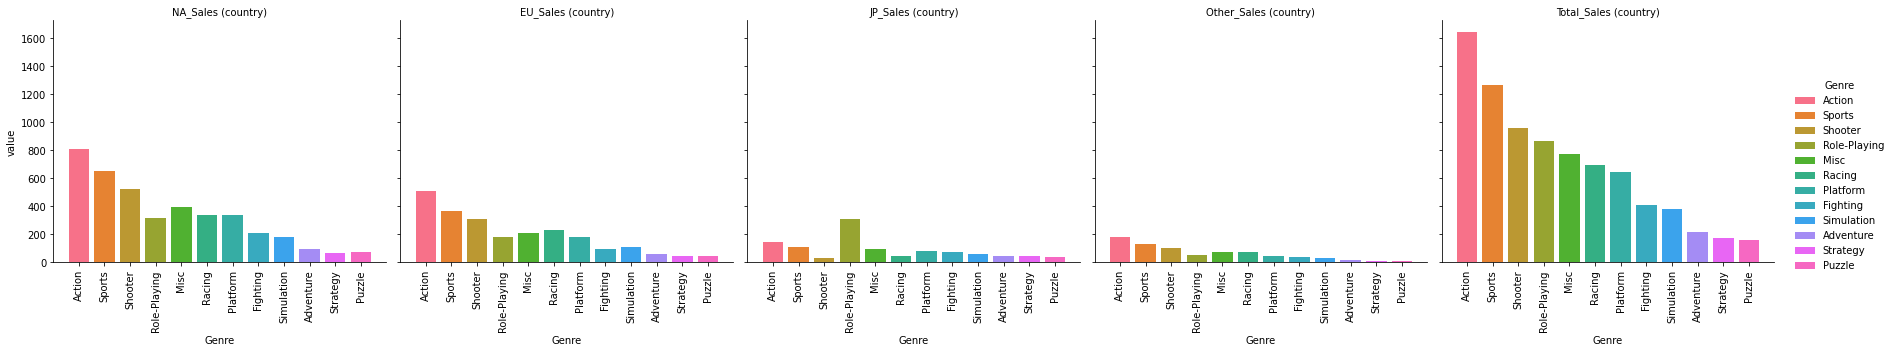

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt


#ax = sns.catplot(kind="bar", data=tidy1, x = "Genre", y="value", col="Country", col_wrap=5)
ax = sns.FacetGrid(tidy1, col='Country', hue='Genre', col_wrap=5, sharey=True, sharex=True, height= 3,size= 5)
ax.map(plt.bar, 'Genre', 'value' )
ax.set_titles("{col_name} (country)")
ax.set_xticklabels(rotation=90)
ax.fig.tight_layout()
ax.add_legend()
plt.show()

## **2.연도별 게임의 트렌드가 있을까**








*   연도별 장르의 관계
*   연도별 게임 플렛폼의 관계
*   연도별 지역과의 관계
--------------------------------------------------------------------------------


(카이제곱검정)

귀무가설 : 연도와 장르는 서로 독립이다.

*   p-value의 값이 (7.760424373393284e-165)로 0.05보다 작기에 귀무가설을 기각한다.
*   결과 : 장르와 지역은 서로 연관성이 있다.


In [56]:
df_y = df[(df.Year>1993) & (df.Year<2021)]
df_y = df_y.groupby([df_y['Year'],df_y['Genre']]).sum()
df_c = df_y.pivot_table(index = 'Year', columns = 'Genre', values = 'Total_Sales' ,fill_value=0)
chi, pvalue, _, _ = chi2_contingency(observed = df_c, correction=False )
chi, pvalue

(1511.529028852421, 7.760424373393284e-165)



*   연도 별로 특정한 장르가 높은 선호도를 보이는 해가 있다.
*   여러 장르 중 5가지('Action','Shooter','Sports','Role-Playing','Misc')의 높은 비중을 차지하는 장르와 그 이외(etc)의 장르들로 분류를 나눠 분석을 진행한다.



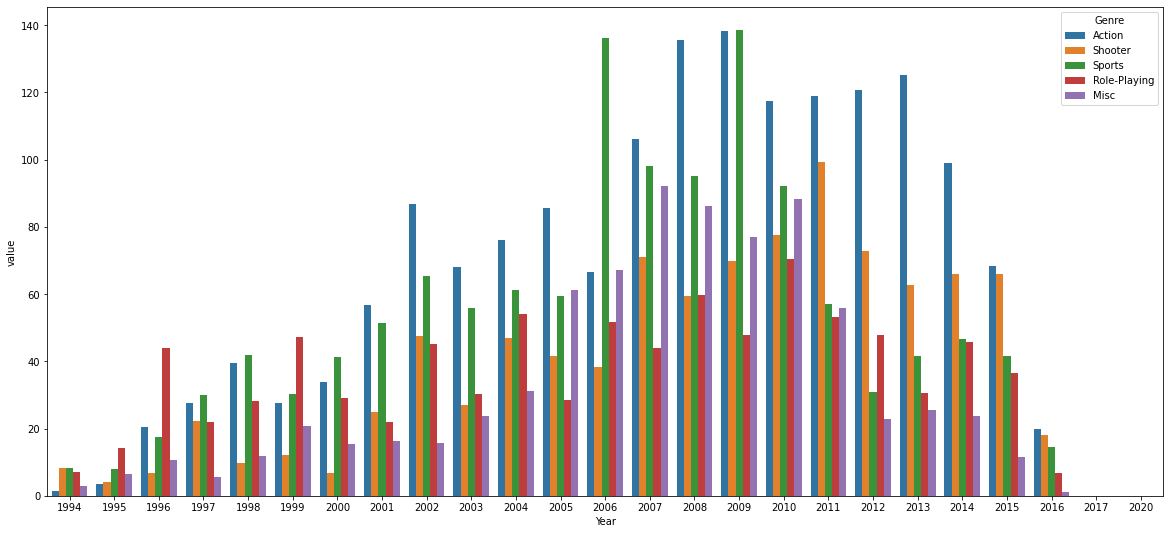

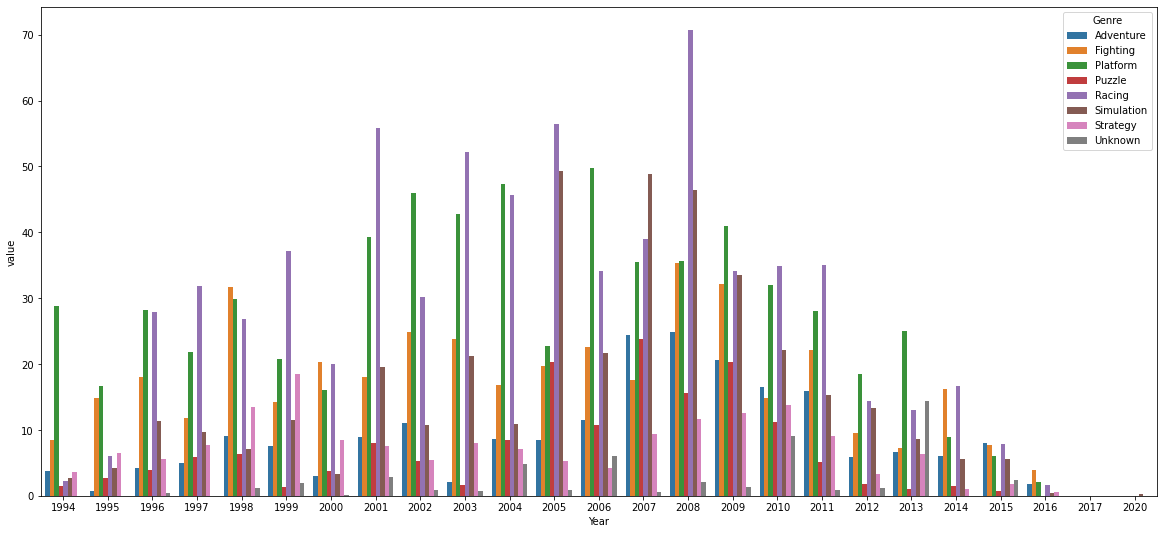

In [57]:
df_yyg = df[(df.Year>1993) & (df.Year<2021)]
df_yyg
df_yyg = df_yyg.groupby([df_yyg['Year'],df_yyg['Genre']]).sum().iloc[:,:]
df_yyg = df_yyg.sort_values(by='Total_Sales' ,ascending=False)
df_yyg = df_yyg.pivot_table(index = 'Genre', columns = 'Year', values = 'Total_Sales' ,fill_value=0)
df_yyg
df_yytg = df_yyg.T
df_yytg.reset_index(inplace=True)
df_yytg
tidy_yg = df_yytg.melt(id_vars = 'Year', value_vars = ['Action','Shooter','Sports','Role-Playing','Misc']) 
tidy_yg
plt.figure(figsize=(20, 9))
sns.barplot(data=tidy_yg, x="Year", y="value",hue='Genre')


tidy_etc = df_yytg.melt(id_vars = 'Year', value_vars = ['Adventure','Fighting','Platform','Puzzle','Racing','Simulation','Strategy','Unknown']) 
tidy_etc
plt.figure(figsize=(20, 9))
sns.barplot(data=tidy_etc, x="Year",y='value',hue='Genre')

In [58]:
df_c.loc['Total'] = df_c.sum()
df_c.sort_values(by='Total',axis=1,ascending=False, inplace=True)
df_c
df_cg = df_c.iloc[:-1,:5]
df_etc = df_c.iloc[:-1,5:]
df_cg['ETC'] = df_c.iloc[:-1,5:].sum(axis=1)
df_cg

Genre,Action,Sports,Shooter,Role-Playing,Misc,ETC
Year,,,,,,
1994,1.55,8.41,8.30,7.13,2.86,50.97
1995,3.58,7.99,4.15,14.27,6.39,51.73
1996,20.60,17.42,6.90,43.99,10.66,99.58
1997,27.59,30.04,22.16,21.82,5.68,93.78
1998,39.41,41.75,9.80,28.09,11.84,125.44
1999,27.62,30.21,12.23,47.24,20.68,113.14
2000,33.89,41.24,6.83,29.04,15.55,75.08
2001,56.68,51.47,24.81,22.02,16.39,160.12
2002,86.65,65.31,47.64,45.09,15.63,134.65


 

*   각연도별로 장르의 핀매량이 연관이 있는데 특히 시대상황으로 월드컵이 열리는 해에는 스포츠 장르의 게임이 많은 판매를 올리는걸 볼 수 있다.
*   특이점으로 2009년도에는 올림픽과 월드컵의 해 사이에 끼인 년도로 시대상황의 영향을 받은 것으로 추측
*   또한 전체적으로 시간이 지날수록 고르게 분포하는 장르의 선호보다는 특정 장르의 선호도가 높아지는걸 볼 수 있다.
*   여기서 중요하게 살펴볼 점으로 Role-Playing 장르는 선호도의 변화가 작은 것을 볼 수 있다. 이것으로 보아 Role-Playing 장르는 특정한 선호층이 형성이 되어있고 꾸준히 유지가 된다는 걸 알 수 있다.  



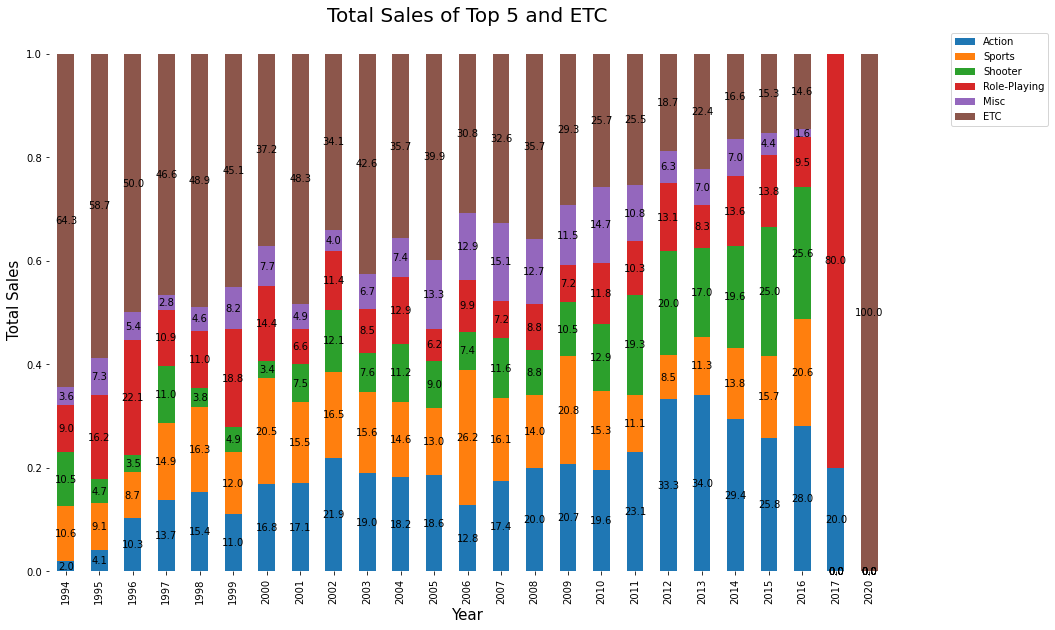

In [59]:
for i in range(len(df_cg.index)):
  df_cg.iloc[i] = df_cg.iloc[i]/df_cg.iloc[i].sum()
    
ax = df_cg.plot.bar(stacked=True, figsize=(15,10))
plt.title('Total Sales of Top 5 and ETC', fontsize=20)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Total Sales',fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f"%(height*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')
plt.sca(ax)
plt.box(False)

**연도와 지역과의 관계**

(카이제곱검정)

귀무가설 : 연도와 장르는 서로 독립이다.

*   p-value의 값이 (5.659330461475277e-45)로 0.05보다 작기에 귀무가설을 기각한다.
*   결과 : 연도와 지역은 서로 연관성이 있다.

In [60]:
df_yy = df[(df.Year>1993) & (df.Year<2021)]
df_yy = df_yy.groupby(df_yy['Year']).sum().iloc[:,:]
df_yy = df_yy.sort_values(by='Total_Sales' ,ascending=False)
chi, pvalue, _, _ = chi2_contingency(observed = df_yy, correction=False )
chi, pvalue

(436.99967641509596, 5.659330461475277e-45)



*   2007 ~ 2009 사이에 전체적인 판매량이 늘어나는 것을 볼 수 있다.
*   [JP]는 2005 ~ 2007, [EU]는 2007~2009, [NA]는 2006 ~ 2008, [Other]은 2006 ~ 2008에 늘어나는 것을 볼 수 있다.



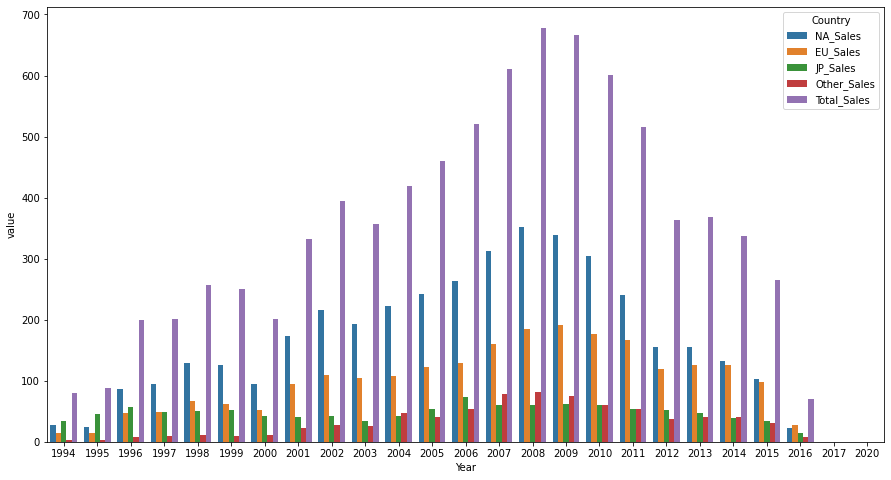

In [61]:
df_yy = df[(df.Year>1993) & (df.Year<2021)]
df_yy
df_yy = df_yy.groupby(df_yy['Year']).sum().iloc[:,:]
df_yy = df_yy.sort_values(by='Total_Sales' ,ascending=False)
df_yy
df_yyt = df_yy.T
df_yyt.reset_index(inplace=True)
df_yyt
tidy_y = df_yyt.melt(id_vars = 'index', value_vars = df_yyt.columns[1:]) 
tidy_y = tidy_y.rename(columns= {'index': 'Country'})
tidy_y
plt.figure(figsize=(15, 8))
sns.barplot(data=tidy_y, x="Year", y="value",hue='Country')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


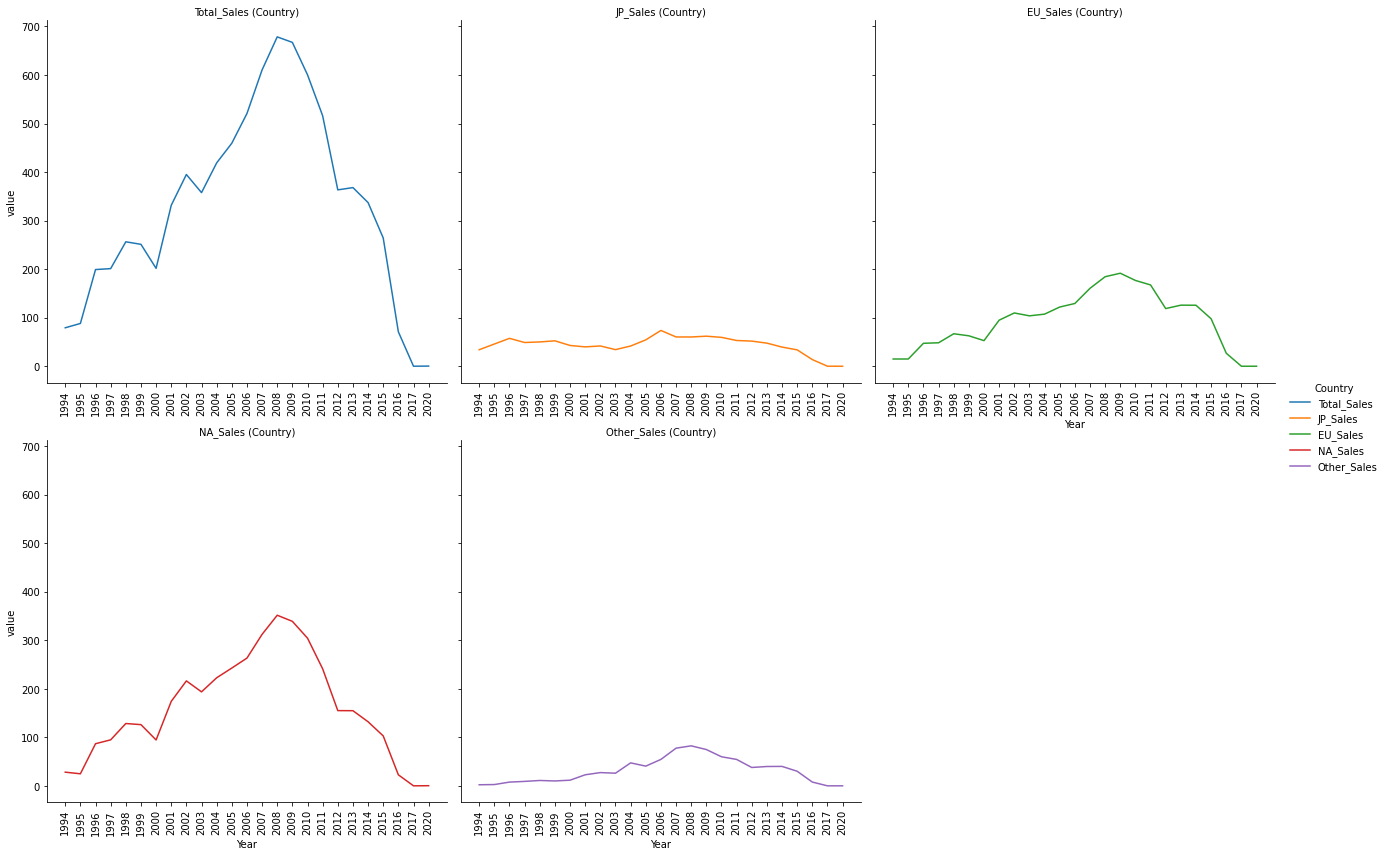

In [90]:
tidy_y5 = tidy_y.copy()
tidy_y5 = tidy_y5.sort_values(by='Year',ascending=True)
tidy_y5['Year'] = tidy_y5['Year'].astype(str)
ax15 = sns.FacetGrid(tidy_y5, col='Country', hue='Country', col_wrap=3, sharey=True, sharex=False, height= 3,size= 6)
ax15.map(sns.lineplot, 'Year', 'value' )
ax15.set_titles("{col_name} (Country)")
ax15.set_xticklabels(rotation=90)
ax15.fig.tight_layout()
ax15.add_legend()
plt.show()

**연도와 플랫폼의 관계**

(카이제곱검정)

귀무가설 : 연도와 장르는 서로 독립이다.

*   p-value의 값이 (0.0)로 0.05보다 작기에 귀무가설을 기각한다.
*   결과 : 연도와 지역은 서로 연관성이 있다.



In [64]:
chi, pvalue, _, _ = chi2_contingency(observed = df_z, correction=False )
chi, pvalue

(24706.095945070396, 0.0)



*   연도와 플랫폼의 heatmap을 보면 많은 플랫폼 중에서 특정 플랫폼들의 판매량이 높은 것을 확인할 수 있다. 
*   대표적인 플랫폼을 보면 PS2, Wii, X360, PS, PS3, DS의 순서대로 높은 판매량을 나타내는 것을 볼 수 있다.
*   PS 시리즈 들은 모두 높은 판매량을 보인다. 
*   2005년 부터 상위 판매량을 보인 플랫폼들도 증가하는 것을 볼 수 있다.



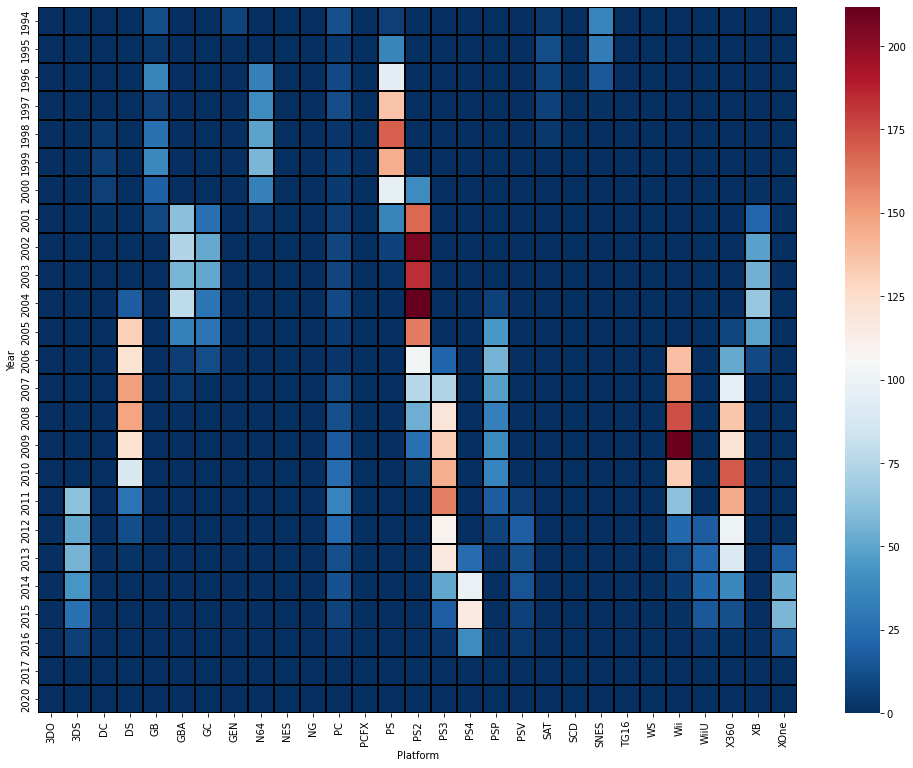

In [63]:
df_z = df[(df.Year>1993) & (df.Year<2021)]
df_z = df_z.groupby([df_z['Year'],df_z['Platform']]).sum()
df_z = df_z.pivot_table(index = 'Year', columns = 'Platform', values = 'Total_Sales' ,fill_value=0)
plt.figure(figsize=(17,13))
sns.heatmap(df_z, cmap= 'RdBu_r', linewidths=1, linecolor='black',annot=False, fmt='.2f')


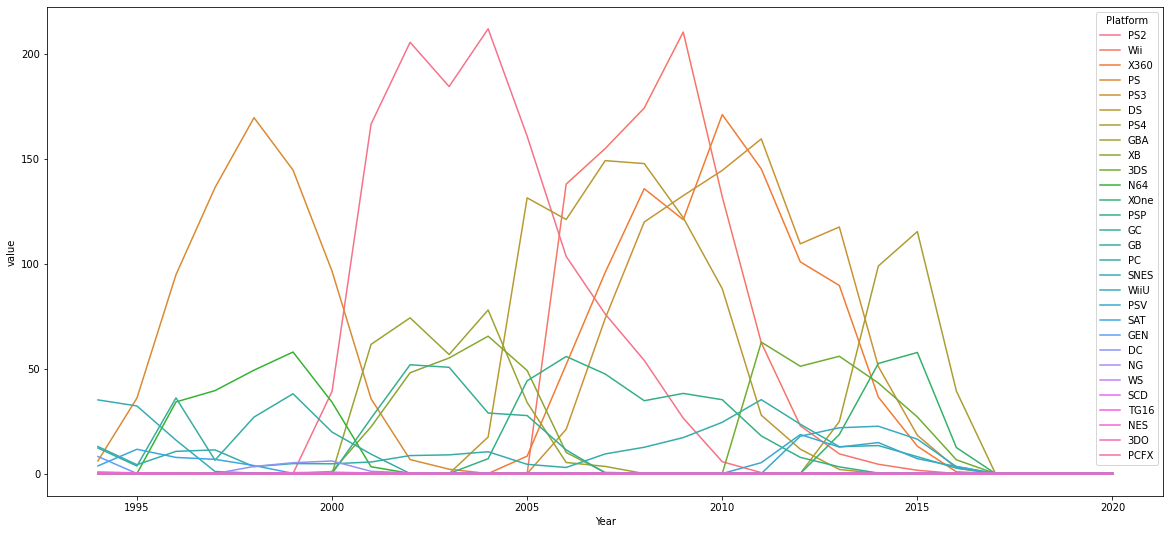

In [65]:
df_zt = df_z.T
df_zt.reset_index(inplace=True)
df_zt
tidy_z = df_zt.melt(id_vars = 'Platform', value_vars = df_yyt.columns[1:]) 
tidy_zs = tidy_z.sort_values(by='value',ascending=False)
tidy_zs
plt.figure(figsize=(20, 9))
sns.lineplot(data=tidy_zs, x="Year",y='value',hue='Platform')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


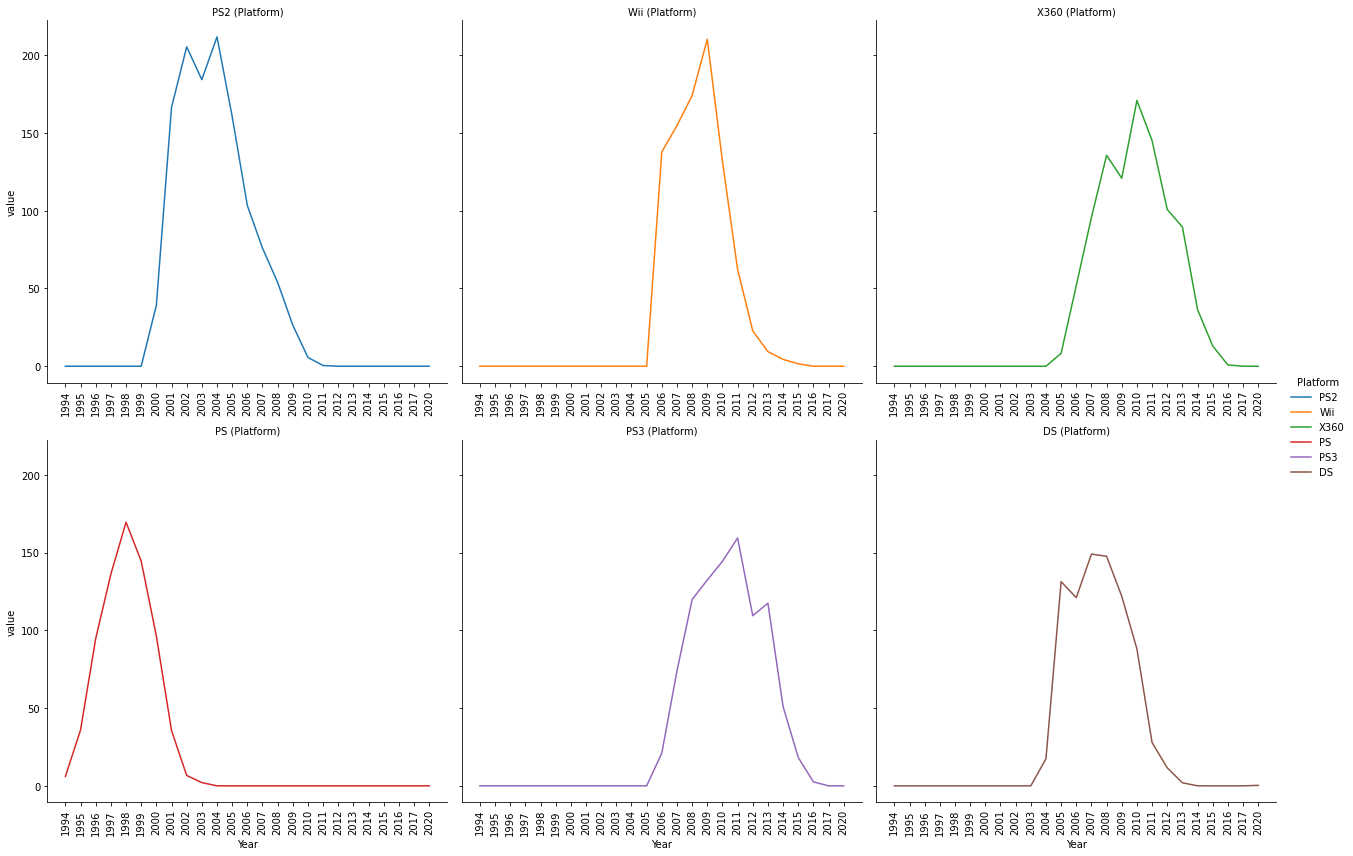

In [66]:
df_zt1 = df_zt.copy()
df_zt1
df_zt1['Total_Platform'] = df_zt1[df_zt.columns[1:]].sum(axis=1)
df_zt1
df_zt2 = df_zt1.sort_values(by='Total_Platform',ascending=False)
df_zt2 = df_zt2.head(6)
df_zt2
tidy_z2 = df_zt2.melt(id_vars = 'Platform', value_vars = df_yyt.columns[1:]) 
tidy_zs2 = tidy_z2.sort_values(by='value',ascending=False)
tidy_zs2
tidy_zs2 = tidy_zs2.sort_values(by='Year',ascending=True)
tidy_zs2['Year'] = tidy_zs2['Year'].astype(str)
ax11 = sns.FacetGrid(tidy_zs2, col='Platform', hue='Platform', col_wrap=3, sharey=True, sharex=False, height= 3,size= 6)
ax11.map(sns.lineplot, 'Year', 'value' )
ax11.set_titles("{col_name} (Platform)")
ax11.set_xticklabels(rotation=90)
ax11.fig.tight_layout()
ax11.add_legend()
plt.show() 

**게임과 지역의 관계**

(카이제곱검정)

귀무가설 : 연도와 장르는 서로 독립이다.

*   p-value의 값이 (1.0))로 0.05보다 크기에 귀무가설을 기각하지 않는다.
*   결과 : 연도와 지역은 서로 독립이다.

In [67]:
df_n1 = df[(df.Year>1993) & (df.Year<2021)] 

df_n1 = df_n1.groupby('Name').sum().iloc[:-1,1:-1]
df_n1
chi, pvalue, _, _ = chi2_contingency(observed = df_n1, correction=False )
chi, pvalue

(5903.547245211745, 1.0)



*   지역에 관해 가장 많은 판매량을 보인 10개의 게임을 분석한다.
*   각 지역에서의 게임 판매량은 장르와 비슷한 수치를 보여준다.
*   지역에서의 판매량은 게임의 종류보다는 장르와 연관되는 판매량을 보여준다.(지역과 게임은 연관성이 없다.)
*   특이점으로 특정한 시기(2006년)에 Wii Sports가 많은 판매량을 보여주는데 위에서 설명한 것과 같게 특정시기에 시대상황에 맞춰 순간적으로 높은 판매량을 나타내는 것을 알 수 있다.


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


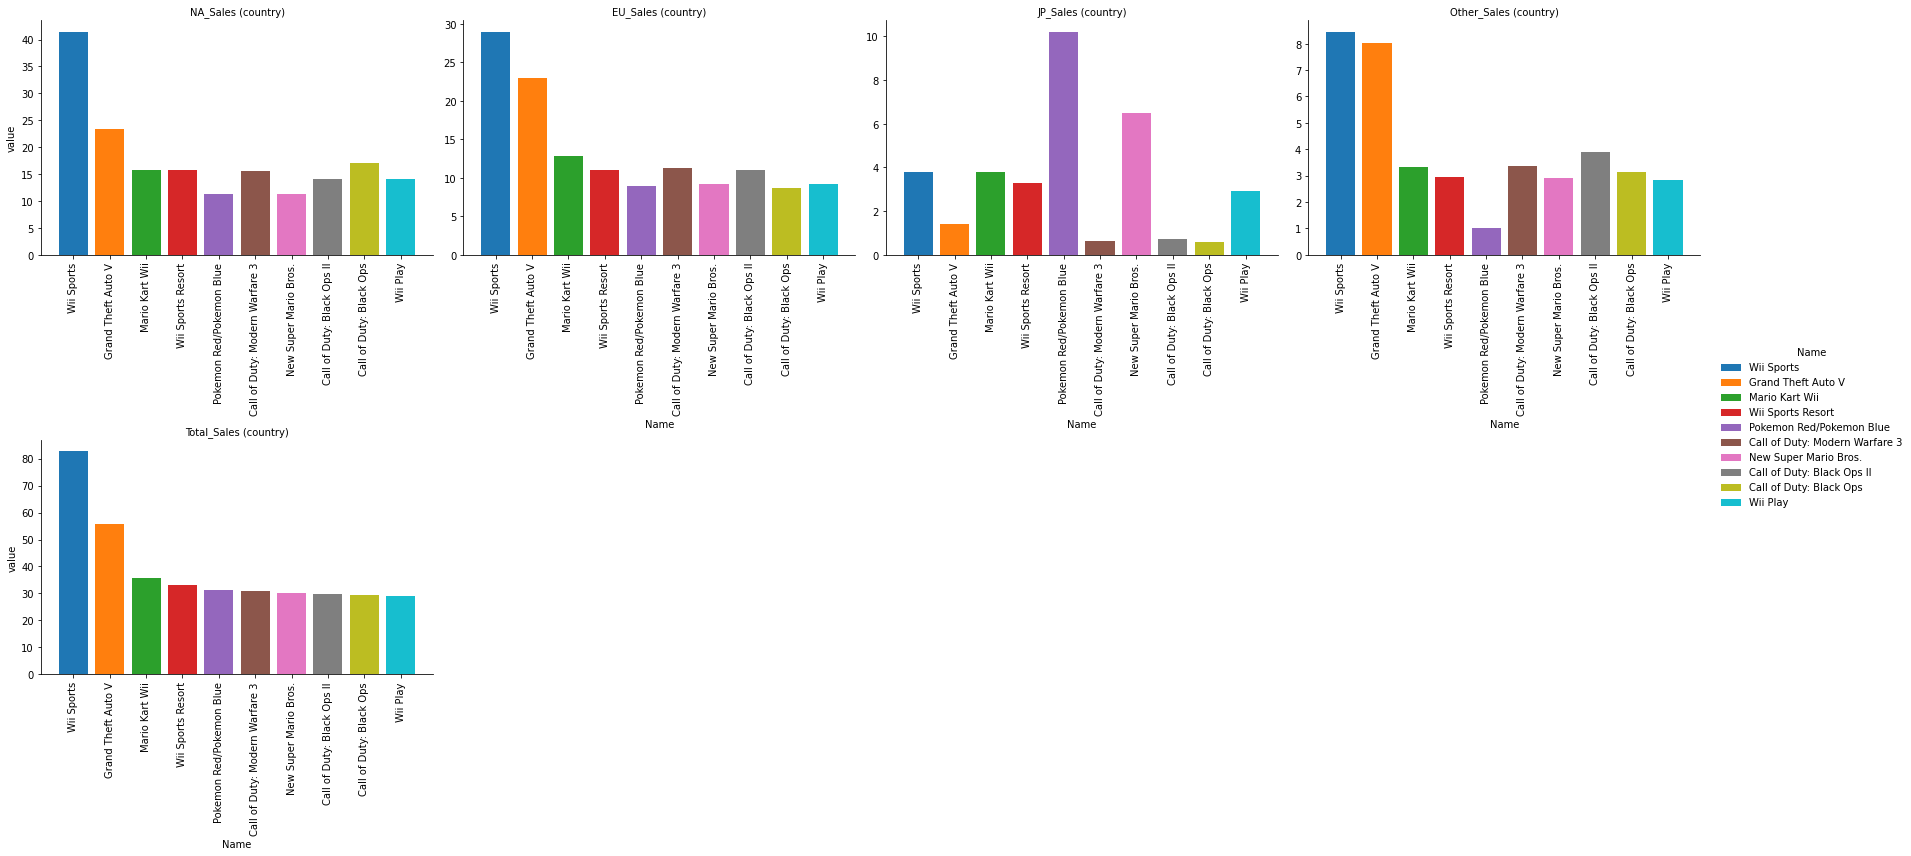

In [68]:
df_n = df[(df.Year>1993) & (df.Year<2021)]
df_n = df_n.groupby(df_n['Name']).sum().iloc[:-1,1:]
df_n = df_n.sort_values(by='Total_Sales' ,ascending=False)
df_n_10 = df_n.head(10)

df_n_10t = df_n_10.T
df_n_10t.reset_index(inplace=True)
df_n_10t
tidy2 = df_n_10t.melt(id_vars = 'index', value_vars = df_n_10t.columns[1:]) 
tidy2 = tidy2.rename(columns= {'index': 'Country'})
tidy2
ax1 = sns.FacetGrid(tidy2, col='Country', hue='Name', col_wrap=4, sharey=False, sharex=False, height= 3,size= 6)
ax1.map(plt.bar, 'Name', 'value' )
ax1.set_titles("{col_name} (country)")
ax1.set_xticklabels(rotation=90)
ax1.fig.tight_layout()
ax1.add_legend()
plt.show()

In [69]:
df_ny = df[(df.Year>1993) & (df.Year<2021)]
contains = df_ny['Genre'].str.contains("Sports|Action|Shooter|Role-Playing")
df_con = df_ny[contains]
df_con = df_con.groupby([df_con['Year'],df_con['Name'],df_con['Genre']]).sum()
df_nyc = df_con.pivot_table(index = 'Year', columns = ['Name','Genre'], values = 'Total_Sales' ,fill_value=0)
df_nyc_t = df_nyc.T
df_nyc
df_nyc_t['Total'] = df_nyc_t[df_nyc_t.columns[:]].sum(axis=1)
df_nyc_t = df_nyc_t.sort_values(by='Total',ascending=False)
df_nyc_t.reset_index(inplace=True)
df_nyc_t = df_nyc_t.head(10)
df_nyc_t

tidy3 = df_nyc_t.melt(id_vars = ['Name','Genre'], value_vars = df_nyc_t.columns[2:-1]) 
tidy3
tidy3 = tidy3[tidy3.value != 0]
tidy3
tidy3['Year'] = tidy3['Year'].astype(str)
tidy3 

,Name,Genre,Year,value
23,Pokemon Red/Pokemon Blue,Role-Playing,1996,31.38
120,Wii Sports,Sports,2006,82.74
152,Wii Sports Resort,Sports,2009,33.00
159,Call of Duty: Modern Warfare 2,Shooter,2009,25.10
166,Call of Duty: Black Ops,Shooter,2010,29.41
174,Call of Duty: Modern Warfare 3,Shooter,2011,30.84
185,Call of Duty: Black Ops II,Shooter,2012,29.73
191,Grand Theft Auto V,Action,2013,37.77
197,Call of Duty: Ghosts,Shooter,2013,27.37
201,Grand Theft Auto V,Action,2014,17.07




*   연도와 게임의 비교에서 특이점은 순간적으로 높은 판매량을 보인 sports 장르의 게임과 꾸준한 판매량을 보인 shooter 장르의 게임이다. 
*   action 장르의 게임은 [JP]를 제외하고 지역마다 판매량이 높은 장르이기에 Action 장르의 게임도 높은 판매량을 차지하고 있다. top 10의 게임 중 액션 장르의 게임은 시간이 흐를수록 판매량의 하락을 볼 수 있다.



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


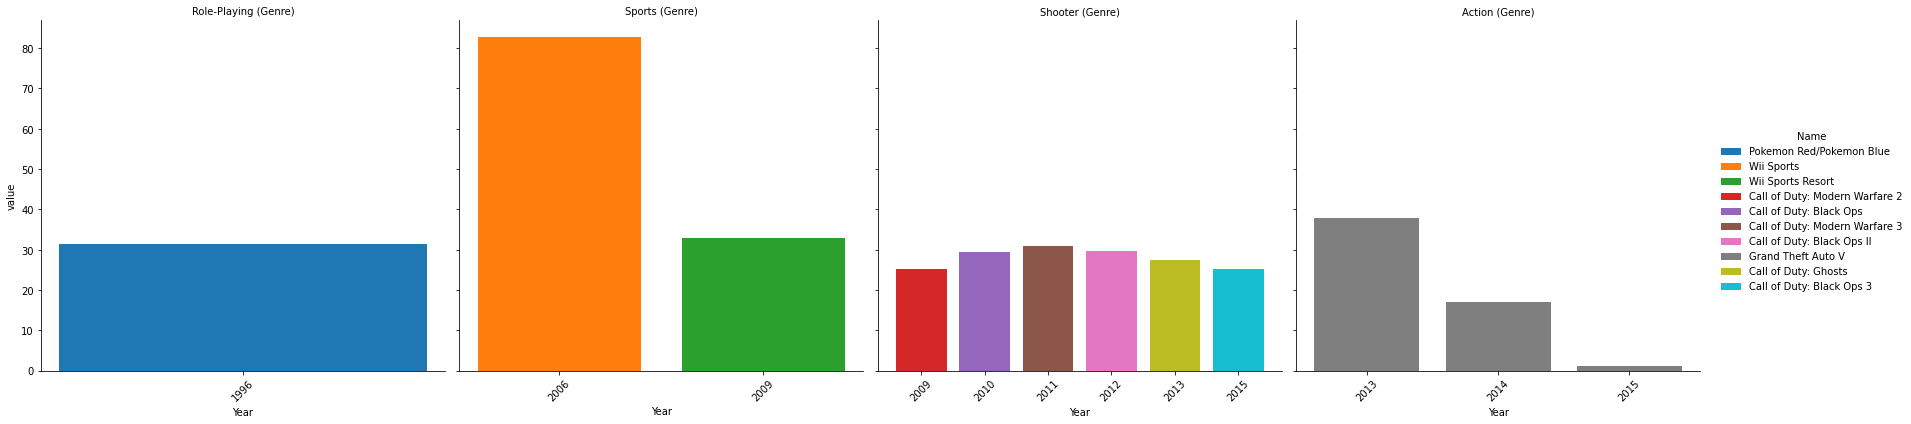

In [70]:
ax3 = sns.FacetGrid(tidy3, col='Genre', hue='Name', col_wrap=4, sharey=True, sharex=False, height= 3,size= 6)
ax3.map(plt.bar, 'Year','value')
ax3.set_titles("{col_name} (Genre)")
ax3.set_xticklabels(rotation=45)
ax3.fig.tight_layout()
ax3.add_legend()
plt.show()

In [81]:
df_nyf5 = df[(df.Year>1993) & (df.Year<2021)]
contains1 = df_nyf5['Genre'].str.contains("Sports|Action|Shooter|Role-Playing")
df_con1 = df_nyf5[contains1]
df_con2 = df_con1.groupby([df_con1['Year'],df_con1['Name'],df_con1['Genre'],df_con1['Platform']]).sum()
df_con2.sort_values(by='Total_Sales',ascending=False)
df_nycf = df_con2.pivot_table(index = 'Year', columns = ['Name','Genre','Platform'], values = 'Total_Sales' ,fill_value=0)
df_nycf
df_nycf_t = df_nycf.T
df_nycf_t
df_nycf_t['Total'] = df_nycf_t[df_nycf_t.columns[:]].sum(axis=1)
df_nycf_t = df_nycf_t.sort_values(by='Total',ascending=False)
df_nycf_t.reset_index(inplace=True)
df_nycf_t = df_nycf_t
df_nycf_t

tidy7 = df_nycf_t.melt(id_vars = ['Name','Genre','Platform'], value_vars = df_nycf_t.columns[3:-1]) 
tidy7
tidy7 = tidy7[tidy7.value != 0]
tidy7
contains8 = tidy7['Name'].str.contains("Call of Duty|Theft Auto V	|Wii Sports|Role-Pokemon Red/Pokemon Blue	")
tidy8 = tidy7[contains8]
tidy8

,Name,Genre,Platform,Year,value
81202,Call of Duty: Finest Hour,Shooter,PS2,2004,2.88
81798,Call of Duty: Finest Hour,Shooter,XB,2004,1.22
83509,Call of Duty: Finest Hour,Shooter,GC,2004,0.40
89469,Call of Duty 2,Shooter,X360,2005,2.02
95310,Call of Duty 2,Shooter,PC,2005,0.06
97104,Wii Sports,Sports,Wii,2006,82.74
97408,Call of Duty 3,Shooter,X360,2006,2.71
97767,Call of Duty 3,Shooter,PS3,2006,1.52
98131,Call of Duty 3,Shooter,PS2,2006,1.07
105232,Call of Duty 4: Modern Warfare,Shooter,X360,2007,9.32




*   플랫폼별 게임을 비교해보면 x360, pc, ps3는 다양한 게임의 분포를 나타내는 것을 볼 수있다.

*   ps4, xone 플랫폼의 게임은 꾸준히 증가 하는 것을 볼 수 있다.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


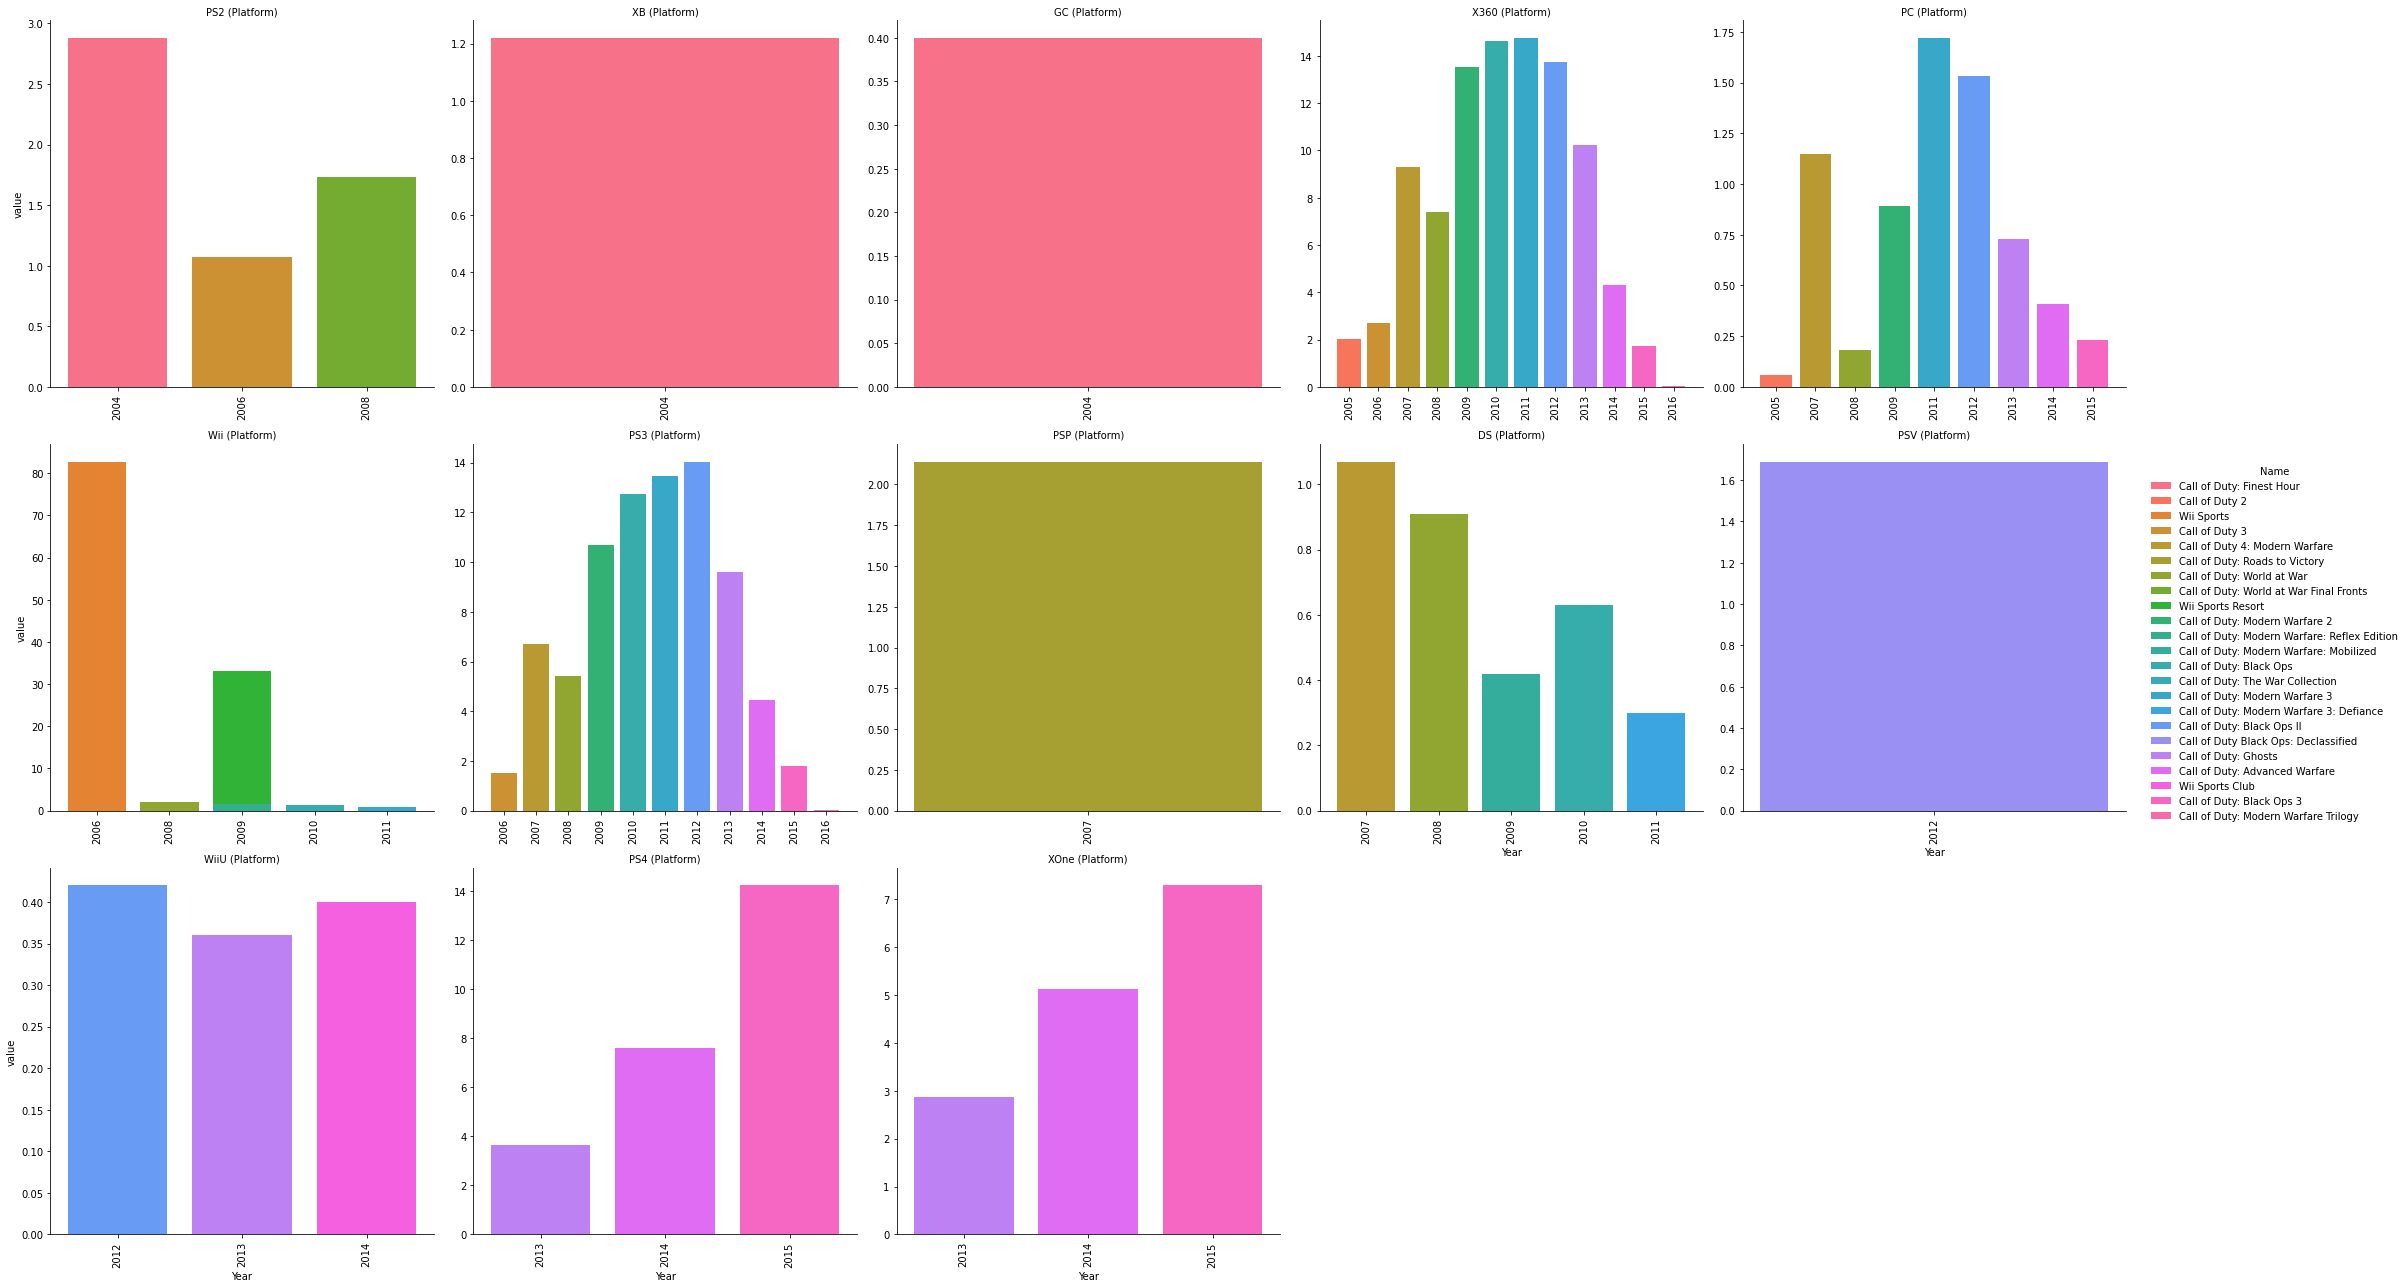

In [87]:
tidy8['Year'] = tidy8['Year'].astype(str)
ax13 = sns.FacetGrid(tidy8, col='Platform', hue='Name', col_wrap=5, sharey=False, sharex=False, height= 3,size= 6)
ax13.map(plt.bar, 'Year', 'value' )
ax13.set_titles("{col_name} (Platform)")
ax13.set_xticklabels(rotation=90)
ax13.fig.tight_layout()
ax13.add_legend()
plt.show() 



*  top 10 게임의 전체적인 판매 점유율을 보았을 때 Wii Sports 게임은 시대상황에 따라 순간적으로 높은 판매량을 보였고 Grand Theft Auto V 게임은 지역에 따라 전체적인 게임 시장에서 action 장르의 선호에 따라 높은 판매량을 보였다. 그리고 주목할 점으로 call of duty 시리즈의 점유율은 전체적으로 고른분포를 유지하며 꾸준한 판매량을 유지하고 있는 것을 볼 때 많은 선호 계층을 형성 한 것을 볼 수 있다.




                                    value
Name                                     
Wii Sports                      22.314518
Grand Theft Auto V              15.081313
Wii Sports Resort                8.899916
Pokemon Red/Pokemon Blue         8.463011
Call of Duty: Modern Warfare 3   8.317376
Call of Duty: Black Ops II       8.018016
Call of Duty: Black Ops          7.931713
Call of Duty: Ghosts             7.381537
Call of Duty: Black Ops 3        6.823269
Call of Duty: Modern Warfare 2   6.769330


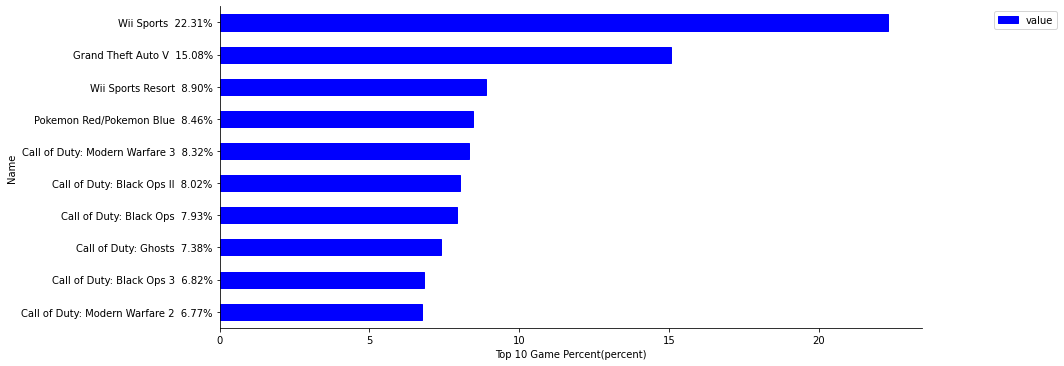

In [72]:
import matplotlib.pyplot as plt
tidy4 = tidy3.set_index('Name')
tidy4
win_percent = (
     tidy4.groupby(level='Name', as_index=True)
     .agg({"value" : "sum"})[["value"]]\
     .apply(lambda x: 100*x/x.sum())\
     )
print(win_percent.sort_values(by='value',ascending=False))
win_percent1 = win_percent.sort_values(by='value',ascending=True)
win_percent1
win_percent1.reset_index(inplace=True)
new_labels = [i+'  {:.2f}%'.format(j) for i, j in zip(win_percent1['Name'], win_percent1['value'])]

aw = win_percent1.plot.barh('Name', 'value', color='b', edgecolor='blue', figsize=(13,5))
plt.yticks(range(len(win_percent1['Name'])), new_labels)
plt.tight_layout()
sns.despine()
plt.xlabel("Top 10 Game Percent(percent)")

for spine in ax.spines.values():
    spine.set_visible(False)

aw.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
aw.axes.get_xaxis().set_visible(True)
aw.tick_params(axis="y", left=True)
plt.show()


